In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import joblib


In [3]:
from sentence_transformers import SentenceTransformer

# Проверяем, загружается ли BERT
model_bert = SentenceTransformer('all-MiniLM-L6-v2')
print("BERT загружен успешно!")

BERT загружен успешно!


In [4]:
# Загрузка данных из CSV файлов
cryptopanic_news = pd.read_csv(r'data/news/cryptopanic_news.csv')
currency = pd.read_csv(r'data/newscurrency.csv')
news_currency = pd.read_csv(r'data/news/news__currency.csv')
source = pd.read_csv(r'data/news/source.csv')

df_BTC_USDT = pd.read_csv(r"data/BTC_USDT_USDT_1h_ohlcv.csv")
df_ETH_USDT = pd.read_csv(r"data/ETH_USDT_USDT_1h_ohlcv.csv")
df_SOL_USDT = pd.read_csv(r"data/SOL_USDT_USDT_1h_ohlcv.csv")

In [5]:
df_BTC_USDT['code'] = 'BTC'
df_ETH_USDT['code'] = 'ETH'
df_SOL_USDT['code'] = 'SOL'

df_price  = pd.concat([df_BTC_USDT, df_ETH_USDT, df_SOL_USDT ], ignore_index=True)

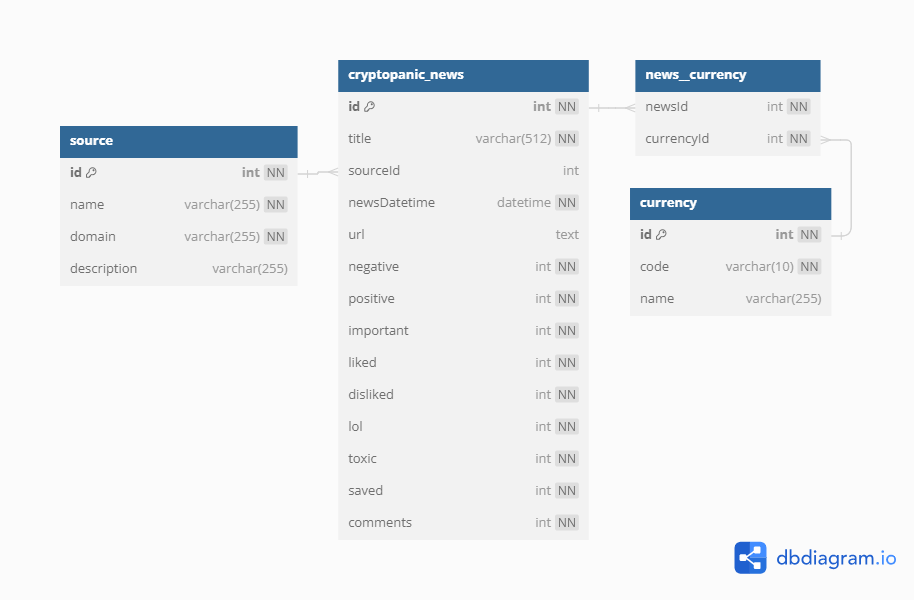

In [6]:
# Выполнение соединений
df_news = cryptopanic_news.merge(news_currency, left_on='id', right_on='newsId') \
                              .merge(currency, left_on='currencyId', right_on='id') \
#                               .merge(source, left_on='sourceId', right_on='id') 



# Примерные названия столбцов
df_news["newsDatetime"] = pd.to_datetime(df_news["newsDatetime"])  # Дата новости
df_price["timestamp"] = pd.to_datetime(df_price["timestamp"])  # Временная метка цены

# Сортируем по времени (обязательно для merge_asof)
df_news = df_news.sort_values("newsDatetime")
df_price = df_price.sort_values("timestamp")

# Джойним по времени с учетом "code"
df_1 = pd.merge_asof(
    df_news, df_price, 
    left_on="newsDatetime", 
    right_on="timestamp", 
    by="code"  # Объединяем только строки с одинаковым кодом валюты
)

df_2 = df_1[~df_1['open'].isna()]
len(df_1), len(df_2)

(277481, 41091)

### create target

In [7]:
N = 6  # Горизонт прогноза

# Делаем копию цен и сдвигаем время вперёд на N часов
df_price_shifted = df_2[["code", "timestamp", "close"]].copy()
df_price_shifted["timestamp"] += pd.Timedelta(hours=N)

# Джойним с `df_2`, чтобы добавить цену через N часов
df_2 = pd.merge_asof(
    df_2.sort_values("newsDatetime"), 
    df_price_shifted.sort_values("timestamp"), 
    left_on="newsDatetime", 
    right_on="timestamp", 
    by="code", 
    suffixes=("", f"_t{N}")  
)

# Создаём бинарный таргет: 1 = цена выросла, 0 = цена упала
df_2[f"target_{N}h_binary"] = (df_2[f"close_t{N}"] > df_2["close"]).astype(int)

df_2[[f"target_{N}h_binary", "newsDatetime", "close", f"close_t{N}"]].head(3)

,target_6h_binary,newsDatetime,close,close_t6
0,0,2020-04-16 05:02:12,6632.80,NaN
1,0,2020-05-13 11:16:19,190.96,NaN
2,0,2020-05-14 23:06:34,203.31,190.96


In [8]:
N = 6  # Горизонт прогноза

# Выбираем фичи для модели
features = [
    "positive", "negative", "toxic", "important", "liked", 
    "disliked", "comments", "sourceId"
]

# Преобразуем время публикации в дополнительные признаки
df_2["hour"] = df_2["newsDatetime"].dt.hour  # Час дня
df_2["weekday"] = df_2["newsDatetime"].dt.weekday  # День недели (0=Пн, 6=Вс)
features += ["hour", "weekday"]

# Преобразуем текст заголовков в TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
X_text = vectorizer.fit_transform(df_2["title"].fillna(""))

# Собираем финальный массив признаков
X_numeric = df_2[features].fillna(0)
X = np.hstack((X_numeric, X_text.toarray()))
y = df_2[f"target_{N}h_binary"]

# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем CatBoost
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train)

# Оцениваем точность
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

0:	learn: 0.6927328	total: 285ms	remaining: 2m 21s
100:	learn: 0.6769750	total: 22.7s	remaining: 1m 29s
200:	learn: 0.6567119	total: 47.4s	remaining: 1m 10s
300:	learn: 0.6392455	total: 1m 11s	remaining: 47.2s
400:	learn: 0.6232008	total: 1m 37s	remaining: 24.1s
499:	learn: 0.6078434	total: 2m 1s	remaining: 0us
Accuracy: 0.5667


In [9]:
# Горизонт прогноза
N = 6  

# Выбираем фичи для модели
features = [
    "positive", "negative", "toxic", "important", "liked", 
    "disliked", "comments", "sourceId"
]

# Преобразуем время публикации в дополнительные признаки
df_2["hour"] = df_2["newsDatetime"].dt.hour  # Час дня
df_2["weekday"] = df_2["newsDatetime"].dt.weekday  # День недели (0=Пн, 6=Вс)
df_2["title_length"] = df_2["title"].apply(lambda x: len(str(x)))
df_2["is_night"] = df_2["hour"].apply(lambda x: 1 if x < 6 else 0)
df_2["is_weekend"] = df_2["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# Добавляем новые признаки в список
features += ["is_night", "is_weekend", "hour", "weekday", "title_length"]

# === Преобразуем заголовки в эмбеддинги BERT ===
print("Создание эмбеддингов BERT для заголовков...")
model_bert = SentenceTransformer('all-MiniLM-L6-v2', device="cpu")  # Если есть GPU, замени "cpu" на "cuda"
X_text_bert = model_bert.encode(df_2["title"].fillna(""), show_progress_bar=True)

# Собираем финальный массив признаков
X_numeric = df_2[features].fillna(0).to_numpy()  # Числовые фичи
X = np.hstack((X_numeric, X_text_bert))  # Объединяем всё
y = df_2[f"target_{N}h_binary"]

# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем CatBoost
print("Обучение модели...")
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train)

# Оцениваем точность
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

Создание эмбеддингов BERT для заголовков...


Batches:   0%|          | 0/1285 [00:00<?, ?it/s]

Обучение модели...
0:	learn: 0.6926629	total: 340ms	remaining: 2m 49s
100:	learn: 0.6527773	total: 30.2s	remaining: 1m 59s
200:	learn: 0.6056114	total: 59s	remaining: 1m 27s
300:	learn: 0.5636224	total: 1m 28s	remaining: 58.6s
400:	learn: 0.5271451	total: 1m 56s	remaining: 28.8s
499:	learn: 0.4943728	total: 2m 26s	remaining: 0us
Accuracy: 0.5997


In [10]:
MODEL_PATH = "catboost_news_model.pkl"
joblib.dump(model, MODEL_PATH)

['catboost_news_model.pkl']

### Код пайплайна

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier
from torch import cuda
import joblib  # Для сохранения модели

# === Глобальные настройки ===
N = 6  # Горизонт прогноза (через сколько часов проверяем рост цены)
BATCH_SIZE = 32  # Размер батча для BERT
MODEL_PATH = "catboost_news_model.pkl"  # Файл для сохранения модели
BERT_MODEL_NAME = "paraphrase-MiniLM-L3-v2"  # Лёгкая версия BERT

# === 1. Функция предобработки данных ===
def preprocess_data(df, is_training=True):
    """Формирует признаки и кодирует текст BERT'ом"""
    print(" Предобработка данных...")

    # Создаём признаки времени
    df["hour"] = df["newsDatetime"].dt.hour
    df["weekday"] = df["newsDatetime"].dt.weekday
    df["title_length"] = df["title"].apply(lambda x: len(str(x)))
    df["is_night"] = df["hour"].apply(lambda x: 1 if x < 6 else 0)
    df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)

    # Новостной фон (средняя тональность за 6 часов)
    df = df.sort_values("newsDatetime")
    df["avg_positive_6h"] = df.groupby("code")["positive"].transform(lambda x: x.rolling("6h").mean())
    df["avg_negative_6h"] = df.groupby("code")["negative"].transform(lambda x: x.rolling("6h").mean())

    # Изменение цены перед новостью
    df["price_change_6h"] = df.groupby("code")["close"].pct_change(periods=6)

    # Выбираем признаки
    features = [
        "positive", "negative", "toxic", "important", "liked", "disliked", "comments", "sourceId",
        "is_night", "is_weekend", "hour", "weekday", "title_length",
        "avg_positive_6h", "avg_negative_6h", "price_change_6h"
    ]

    # Устройство для BERT
    device = "cuda" if cuda.is_available() else "cpu"

    # Загружаем BERT и кодируем заголовки
    print(f"Кодирование заголовков BERT ({BERT_MODEL_NAME})...")
    model_bert = SentenceTransformer(BERT_MODEL_NAME, device=device)
    X_text_bert = model_bert.encode(df["title"].fillna("").tolist(), batch_size=BATCH_SIZE, show_progress_bar=True)

    # Объединяем числовые признаки и эмбеддинги BERT
    X_numeric = df[features].fillna(0).to_numpy()
    X = np.hstack((X_numeric, X_text_bert))

    # Если это обучение, возвращаем и таргет
    if is_training:
        y = df[f"target_{N}h_binary"]
        return X, y
    return X

# === 2. Функция обучения модели ===
def train_model(df):
    """Обучает CatBoost и сохраняет модель"""
    print(" Обучение модели...")
    
    # Готовим данные
    X, y = preprocess_data(df)

    # Разбиваем на train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучаем CatBoost
    model = CatBoostClassifier(iterations=1000, depth=8, learning_rate=0.05, l2_leaf_reg=3, verbose=100)
    model.fit(X_train, y_train)

    # Оцениваем точность
    accuracy = model.score(X_test, y_test)
    print(f" Точность модели: {accuracy:.4f}")

    # Сохраняем модель
    joblib.dump(model, MODEL_PATH)
    print(f" Модель сохранена в {MODEL_PATH}")

# === 3. Функция предсказания на новых новостях ===
def predict_new_news(df_new):
    """Делает предсказание для новых новостей"""
    print(" Предсказание новых новостей...")

    # Загружаем обученную модель
    model = joblib.load(MODEL_PATH)

    # Обрабатываем новые данные
    X_new = preprocess_data(df_new, is_training=False)

    # Предсказываем
    predictions = model.predict(X_new)
    df_new["prediction"] = predictions

    # Выводим первые 5 результатов
    print(df_new[["newsDatetime", "title", "prediction"]].head())
    return df_new


# Пайплайн прогнозирования влияния новостей на цену криптовалют

## Описание
Этот пайплайн анализирует новости и предсказывает, **вызовет ли новость рост цены через N часов**.  
Модель использует **эмбеддинги BERT** для обработки заголовков и **CatBoost** для предсказаний.  

## Входные данные

### 1. Исторические данные (`historical_news_data.csv`)
Этот файл используется для **обучения** модели.  

🔹 **Обязательные колонки:**
| Колонка         | Описание |
|----------------|----------|
| `id_x`        | ID новости |
| `title`       | Заголовок новости |
| `sourceId`    | Источник (ID) |
| `newsDatetime`| Дата и время публикации новости (`YYYY-MM-DD HH:MM:SS`) |
| `positive`    | Позитивная тональность (0-1) |
| `negative`    | Негативная тональность (0-1) |
| `toxic`       | Токсичность (0-1) |
| `important`   | Важность (0-1) |
| `liked`       | Количество лайков |
| `disliked`    | Количество дизлайков |
| `comments`    | Количество комментариев |
| `code`        | Символ криптовалюты (`BTC`, `ETH`, ...) |
| `timestamp`   | Время свечи цены (`YYYY-MM-DD HH:MM:SS`) |
| `open`        | Цена открытия свечи |
| `high`        | Максимальная цена |
| `low`         | Минимальная цена |
| `close`       | Цена закрытия свечи |
| `volume`      | Объём торгов |
| `target_6h_binary` | Целевой таргет (`1` - цена выросла через 6 часов, `0` - упала) |

 **Как получить `target_6h_binary`?**  
Если данных нет, его можно создать автоматически перед обучением.

---

### 2. Новые новости (`new_news_data.csv`)
Этот файл содержит **новые новости**, на которых модель будет делать предсказания.  
🔹 **Обязательные колонки (как в обучении, но без `target_6h_binary`)**  
После обработки добавится колонка **`prediction`** (`1` - цена вырастет, `0` - упадёт).  

---

## Установка зависимостей
Перед запуском убедитесь, что установлены все библиотеки:
```bash
pip install pandas numpy sentence-transformers catboost torch joblib

# Входные данные для предсказания модели

## Что подаётся на вход обученной модели?
После предобработки модель получает **вектор признаков**, включающий:
1. **Числовые признаки (новостные и рыночные)**
2. **Эмбеддинги заголовков, созданные с помощью BERT**

---

## Структура входных данных

### Входной DataFrame перед подачей в модель
Перед тем как модель делает предсказание, каждая строка данных выглядит так:

| Колонка            | Описание |
|--------------------|----------|
| `positive`        | Доля позитивной тональности (0-1) |
| `negative`        | Доля негативной тональности (0-1) |
| `toxic`          | Доля токсичности (0-1) |
| `important`      | Важность новости (0-1) |
| `liked`          | Количество лайков |
| `disliked`       | Количество дизлайков |
| `comments`       | Количество комментариев |
| `sourceId`       | ID источника новости |
| `is_night`       | Опубликована ночью (`1` если <6 утра, иначе `0`) |
| `is_weekend`     | Опубликована в выходные (`1` если Сб/Вс, иначе `0`) |
| `hour`           | Час публикации новости (0-23) |
| `weekday`        | День недели (0=Пн, 6=Вс) |
| `title_length`   | Количество символов в заголовке |
| `avg_positive_6h` | Средняя позитивность новостей за 6 часов |
| `avg_negative_6h` | Средняя негативность новостей за 6 часов |
| `price_change_6h` | Изменение цены за последние 6 часов (`(close_now - close_6h) / close_6h`) |
| **`bert_0 ... bert_383`** | Вектор размером `384` из эмбеддинга заголовка |

---

## Как выглядят данные после обработки?
Пример одной строки, которая подаётся в модель: